# Main Modelling Notebook

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

#### Load Data

In [2]:
# load data
%run -i data_loading.py

173805
79052


C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
employ_title object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
installment float64
ipr float64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
months_since_earliest_credit float64
Indexes computed
19719
59333
PCA: first and last columns where % variance explained >= 99: [62 99]
PCA: first and last columns where % variance explained >= 85: Exception!


#### Set up Modelling Framework

In [3]:
# set up modelling framework
% run -i modelling_framework.py

#### Models without PCA

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


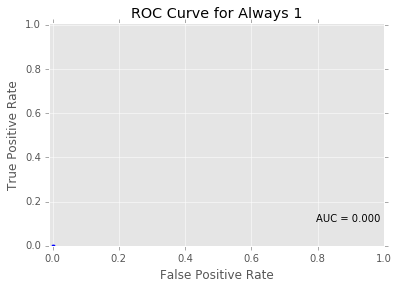

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [4]:
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=0), model_name='Always 1')

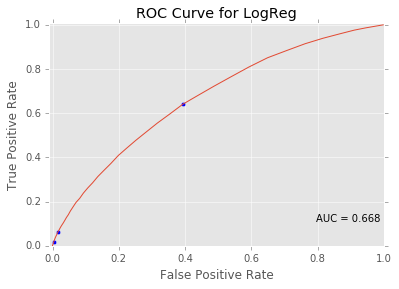

all   score: 0.845  baseline: 0.845   1-prec: 0.847   f1: 0.033  | test score 0.152  1-prec 0.850 f1 0.260  GP 838MM
2011  score: 0.885  baseline: 0.887   wscore: 0.888   f1: 0.025  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.868   f1: 0.012  | test score 0.862  1-prec 0.864
2013  score: 0.816  baseline: 0.818   wscore: 0.824   f1: 0.089  | test score 0.823  1-prec 0.829


In [5]:
eval_model_by_year(lambda: Log_Reg(), model_name='LogReg')

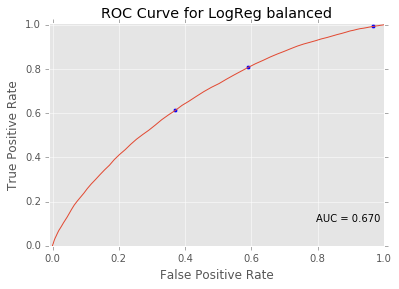

all   score: 0.635  baseline: 0.845   1-prec: 0.903   f1: 0.347  | test score 0.373  1-prec 0.901 f1 0.158  GP 264MM
2011  score: 0.629  baseline: 0.887   wscore: 0.911   f1: 0.237  | test score 0.630  1-prec 0.924
2012  score: 0.629  baseline: 0.867   wscore: 0.912   f1: 0.301  | test score 0.608  1-prec 0.899
2013  score: 0.641  baseline: 0.818   wscore: 0.884   f1: 0.385  | test score 0.634  1-prec 0.887


In [6]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), model_name='LogReg balanced')

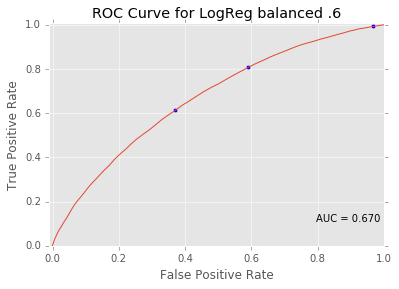

all   score: 0.635  baseline: 0.845   1-prec: 0.924   f1: 0.347  | test score 0.530  1-prec 0.922 f1 0.111  GP -26MM
2011  score: 0.629  baseline: 0.887   wscore: 0.917   f1: 0.237  | test score 0.630  1-prec 0.936
2012  score: 0.629  baseline: 0.867   wscore: 0.932   f1: 0.301  | test score 0.608  1-prec 0.918
2013  score: 0.641  baseline: 0.818   wscore: 0.909   f1: 0.385  | test score 0.634  1-prec 0.906


In [7]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, model_name='LogReg balanced .6')

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


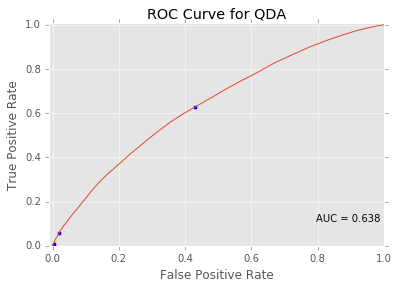

all   score: 0.845  baseline: 0.845   1-prec: 0.847   f1: 0.023  | test score 0.153  1-prec 0.849 f1 0.262  GP 843MM
2011  score: 0.880  baseline: 0.887   wscore: 0.890   f1: 0.070  | test score 0.884  1-prec 0.898
2012  score: 0.866  baseline: 0.867   wscore: 0.867   f1: 0.010  | test score 0.862  1-prec 0.864
2013  score: 0.813  baseline: 0.818   wscore: 0.822   f1: 0.076  | test score 0.819  1-prec 0.830


In [8]:
eval_model_by_year(lambda: QDA(reg_param = 1), model_name='QDA')

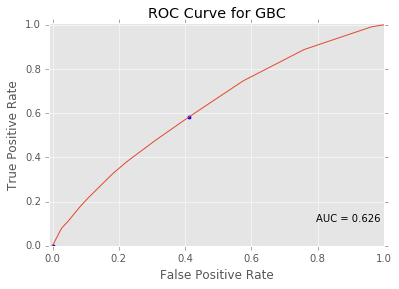

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.015  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [9]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), model_name='GBC')

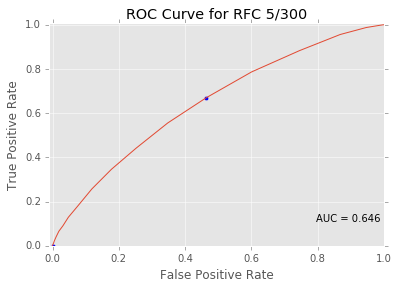

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.000  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [10]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300), model_name='RFC 5/300')

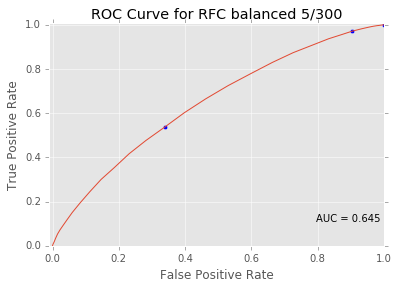

all   score: 0.651  baseline: 0.845   1-prec: 0.892   f1: 0.330  | test score 0.357  1-prec 0.889 f1 0.179  GP 328MM
2011  score: 0.768  baseline: 0.887   wscore: 0.900   f1: 0.214  | test score 0.780  1-prec 0.913
2012  score: 0.658  baseline: 0.867   wscore: 0.900   f1: 0.282  | test score 0.647  1-prec 0.885
2013  score: 0.659  baseline: 0.818   wscore: 0.872   f1: 0.369  | test score 0.660  1-prec 0.874


In [11]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, class_weight = 'balanced', n_estimators=300),
                   model_name='RFC balanced 5/300')

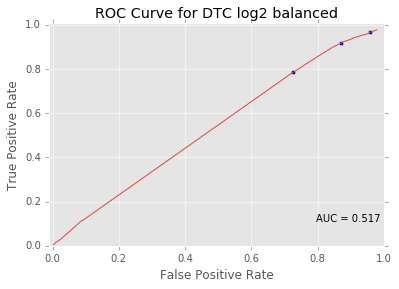

all   score: 0.568  baseline: 0.845   1-prec: 0.876   f1: 0.286  | test score 0.648  1-prec 0.877 f1 0.156  GP -257MM
2011  score: 0.701  baseline: 0.887   wscore: 0.890   f1: 0.165  | test score 0.594  1-prec 0.917
2012  score: 0.574  baseline: 0.867   wscore: 0.885   f1: 0.240  | test score 0.582  1-prec 0.882
2013  score: 0.606  baseline: 0.818   wscore: 0.846   f1: 0.306  | test score 0.596  1-prec 0.844


In [12]:
eval_model_by_year(lambda: DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                  model_name='DTC log2 balanced')

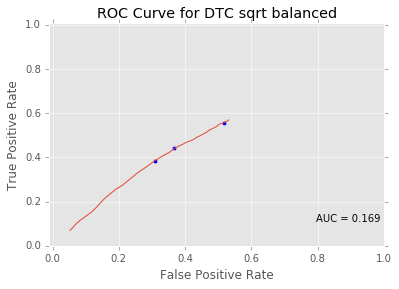

all   score: 0.656  baseline: 0.845   1-prec: 0.862   f1: 0.256  | test score 0.354  1-prec 0.863 f1 0.224  GP 397MM
2011  score: 0.733  baseline: 0.887   wscore: 0.887   f1: 0.150  | test score 0.786  1-prec 0.902
2012  score: 0.684  baseline: 0.867   wscore: 0.875   f1: 0.203  | test score 0.701  1-prec 0.872
2013  score: 0.654  baseline: 0.818   wscore: 0.841   f1: 0.291  | test score 0.649  1-prec 0.842


In [13]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC sqrt balanced')

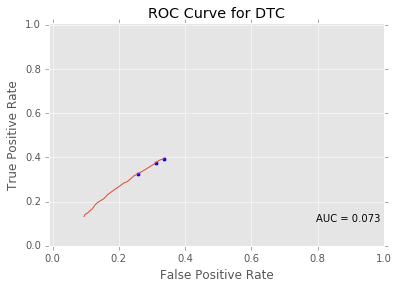

all   score: 0.679  baseline: 0.845   1-prec: 0.858   f1: 0.237  | test score 0.322  1-prec 0.860 f1 0.231  GP 482MM
2011  score: 0.770  baseline: 0.887   wscore: 0.891   f1: 0.155  | test score 0.764  1-prec 0.899
2012  score: 0.715  baseline: 0.867   wscore: 0.879   f1: 0.218  | test score 0.634  1-prec 0.875
2013  score: 0.673  baseline: 0.818   wscore: 0.832   f1: 0.260  | test score 0.687  1-prec 0.842


In [14]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = None, class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC')

In [15]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [16]:
# This takes a very long time for practically no uplift
#eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True), prob_threshold=0.85)

#### Other Models without PCA

In [17]:
# TODO: Try again, this time fitting a regression against the payments received

In [18]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2011   n=2521   d= 286   p: 0.113 | 0.113 | 0.114
y=2012   n=7475   d= 994   p: 0.133 | 0.133 | 0.133
y=2013   n=9723   d=1767   p: 0.182 | 0.182 | 0.182


In [19]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.154521020336
0.230563002681


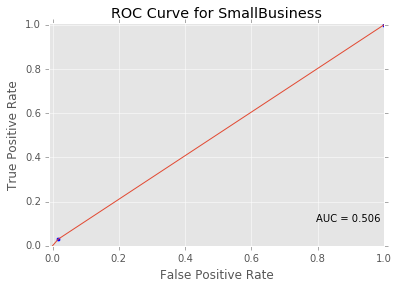

all   score: 0.835  baseline: 0.845   1-prec: 0.847   f1: 0.050  | test score 0.162  1-prec 0.850 f1 0.260  GP 819MM
2011  score: 0.714  baseline: 0.887   wscore: 0.856   f1: 0.070  | test score 0.874  1-prec 0.899
2012  score: 0.852  baseline: 0.867   wscore: 0.868   f1: 0.058  | test score 0.849  1-prec 0.865
2013  score: 0.816  baseline: 0.818   wscore: 0.820   f1: 0.042  | test score 0.821  1-prec 0.826


In [20]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'], model_name='SmallBusiness')

In [21]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [22]:
lr_coeff.sort_values('abs', ascending=False).coeff

loan_amount                                  -2.983795
installment                                   2.702074
employ_title__walmart                        -1.694410
employ_title__manager                        -1.488959
employ_title__U.S._Army                      -1.476162
employ_title__The_Home_Depot                 -1.433260
employ_title__United_Parcel_Service          -1.317520
employ_title__United_States_Postal_Service   -1.011849
employ_title__USPS                            1.000324
employ_title__Director                       -0.964036
employ_title__US_Army                        -0.918992
employ_title__JP_Morgan_Chase                -0.905019
employ_title__State_of_California            -0.852805
employ_title__United_States_Air_Force        -0.846042
employ_title__Department_of_Defense          -0.842420
address_state__IA                             0.835277
employ_title__Home_Depot                      0.834453
employ_title__Driver                         -0.762123
employ_tit

In [23]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

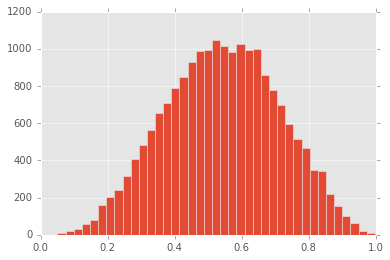

In [24]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [25]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.00    0.333333
0.05    0.413793
0.10    0.541667
0.15    0.579545
0.20    0.620763
0.25    0.670000
0.30    0.698299
0.35    0.760353
0.40    0.804571
0.45    0.834331
0.50    0.857075
0.55    0.868293
0.60    0.904647
0.65    0.925014
0.70    0.941810
0.75    0.958864
0.80    0.966988
0.85    0.972705
0.90    0.957317
0.95    0.964286
Name: loan_status, dtype: float64

In [26]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [27]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [28]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

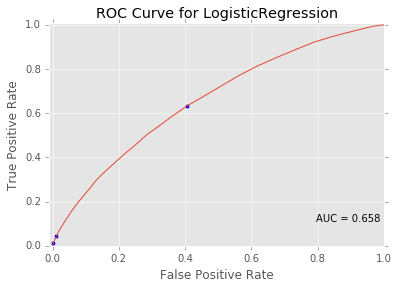

all   score: 0.845  baseline: 0.845   1-prec: 0.847   f1: 0.021  | test score 0.152  1-prec 0.849 f1 0.261  GP 846MM
2011  score: 0.885  baseline: 0.887   wscore: 0.888   f1: 0.025  | test score 0.895  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.008  | test score 0.863  1-prec 0.863
2013  score: 0.816  baseline: 0.818   wscore: 0.822   f1: 0.062  | test score 0.823  1-prec 0.829


In [29]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

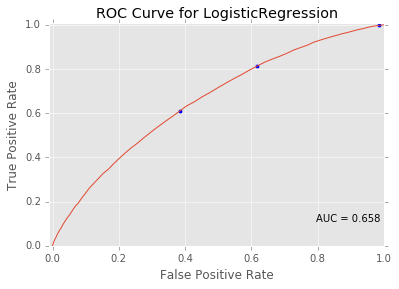

all   score: 0.626  baseline: 0.845   1-prec: 0.901   f1: 0.339  | test score 0.385  1-prec 0.898 f1 0.161  GP 250MM
2011  score: 0.621  baseline: 0.887   wscore: 0.911   f1: 0.235  | test score 0.614  1-prec 0.924
2012  score: 0.613  baseline: 0.867   wscore: 0.908   f1: 0.288  | test score 0.599  1-prec 0.898
2013  score: 0.634  baseline: 0.818   wscore: 0.882   f1: 0.379  | test score 0.628  1-prec 0.884


In [30]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

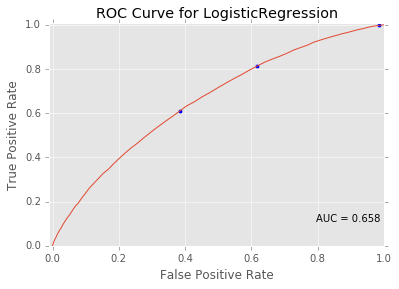

all   score: 0.626  baseline: 0.845   1-prec: 0.922   f1: 0.339  | test score 0.552  1-prec 0.920 f1 0.112  GP -81MM
2011  score: 0.621  baseline: 0.887   wscore: 0.923   f1: 0.235  | test score 0.614  1-prec 0.934
2012  score: 0.613  baseline: 0.867   wscore: 0.928   f1: 0.288  | test score 0.599  1-prec 0.914
2013  score: 0.634  baseline: 0.818   wscore: 0.906   f1: 0.379  | test score 0.628  1-prec 0.902


In [31]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

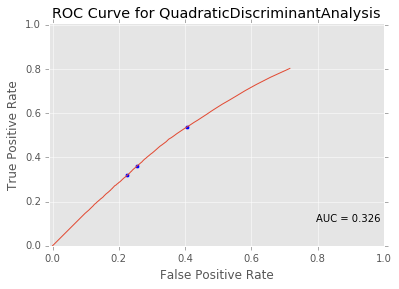

all   score: 0.701  baseline: 0.845   1-prec: 0.866   f1: 0.269  | test score 0.294  1-prec 0.864 f1 0.227  GP 523MM
2011  score: 0.675  baseline: 0.887   wscore: 0.896   f1: 0.194  | test score 0.718  1-prec 0.903
2012  score: 0.703  baseline: 0.867   wscore: 0.878   f1: 0.217  | test score 0.707  1-prec 0.874
2013  score: 0.699  baseline: 0.818   wscore: 0.840   f1: 0.283  | test score 0.682  1-prec 0.844


In [32]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

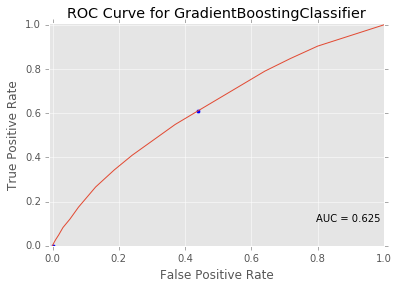

all   score: 0.845  baseline: 0.845   1-prec: 0.845   f1: 0.000  | test score 0.152  1-prec 0.848 f1 0.263  GP 851MM
2011  score: 0.887  baseline: 0.887   wscore: 0.887   f1: 0.006  | test score 0.896  1-prec 0.896
2012  score: 0.867  baseline: 0.867   wscore: 0.867   f1: 0.000  | test score 0.863  1-prec 0.863
2013  score: 0.818  baseline: 0.818   wscore: 0.818   f1: 0.000  | test score 0.825  1-prec 0.825


In [33]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                  x = x_expanded_pca, x_test = x_test_expanded_pca)

## NLP Modeling

#### Top Terms in Each Class

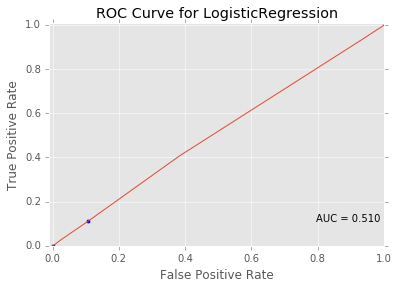

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [34]:
eval_model_by_year(lambda: Log_Reg(), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

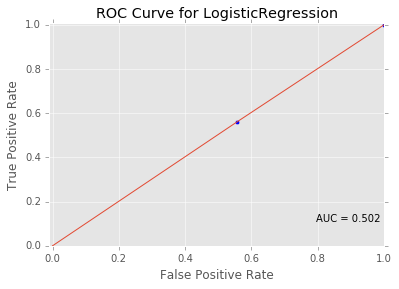

all   score: 0.465  baseline: 0.860   1-prec: 0.862   f1: 0.219  | test score 0.540  1-prec 0.859 f1 0.213  GP 2MM
2011  score: 0.739  baseline: 0.899   wscore: 0.896   f1: 0.110  | test score 0.849  1-prec 0.900
2012  score: 0.790  baseline: 0.865   wscore: 0.866   f1: 0.119  | test score 0.713  1-prec 0.864
2013  score: 0.244  baseline: 0.834   wscore: 0.824   f1: 0.274  | test score 0.464  1-prec 0.823


In [35]:
eval_model_by_year(lambda: Log_Reg(C = 10 ** -6, class_weight = 'balanced'), 
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

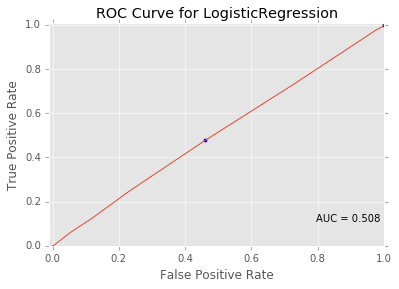

all   score: 0.558  baseline: 0.860   1-prec: nan   f1: 0.212  | test score 0.858  1-prec 0.818 f1 0.002  GP -159MM
2011  score: 0.555  baseline: 0.899   wscore: 0.905   f1: 0.158  | test score 0.550  1-prec 0.876
2012  score: 0.478  baseline: 0.865   wscore: 0.911   f1: 0.218  | test score 0.458  1-prec 0.837
2013  score: 0.534  baseline: 0.834   wscore: 0.847   f1: 0.233  | test score 0.471  1-prec 0.853


In [36]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), prob_threshold = 0.6,
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

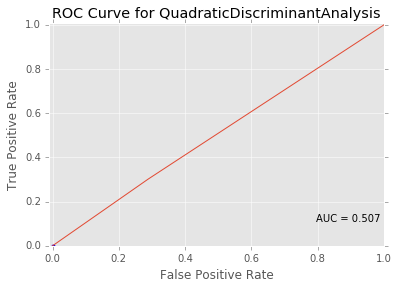

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [37]:
eval_model_by_year(lambda: QDA(reg_param = 1), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

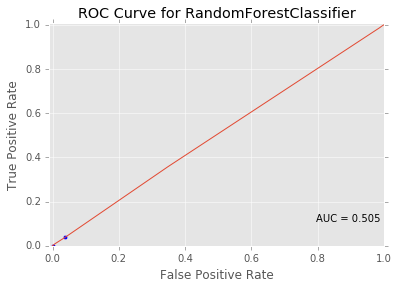

all   score: 0.860  baseline: 0.860   1-prec: 0.860   f1: 0.000  | test score 0.142  1-prec 0.858 f1 0.248  GP 211MM
2011  score: 0.899  baseline: 0.899   wscore: 0.899   f1: 0.000  | test score 0.899  1-prec 0.899
2012  score: 0.865  baseline: 0.865   wscore: 0.865   f1: 0.000  | test score 0.866  1-prec 0.866
2013  score: 0.834  baseline: 0.834   wscore: 0.834   f1: 0.000  | test score 0.827  1-prec 0.827


In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

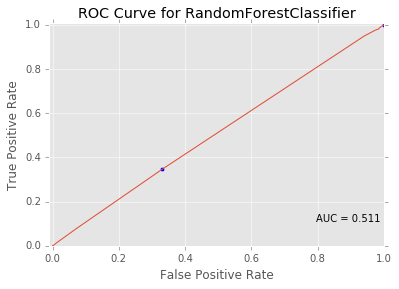

all   score: 0.627  baseline: 0.860   1-prec: 0.861   f1: 0.197  | test score 0.376  1-prec 0.861 f1 0.229  GP 85MM
2011  score: 0.713  baseline: 0.899   wscore: 0.897   f1: 0.130  | test score 0.729  1-prec 0.895


In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300, class_weight = 'balanced'),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test)

#### Full Document-Term Matrix (Reduced with PCA)

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='LogReg PCA Balanced')

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                   x = desc_matrix_pca, x_test = desc_matrix_test_pca,
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='GBC PCA')

## Stacking

In [ ]:
# function to create model stack
def create_model_stack(x_train, y_train):
    model_stack = []

    model_stack.append(Log_Reg(C = 10 ** -5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(LDA(shrinkage = 1, solver = 'lsqr').fit(x_train, y_train))
    model_stack.append(QDA(reg_param = 1).fit(x_train, y_train))
    model_stack.append(RFC(n_estimators = 300, max_depth = 5, class_weight = 'balanced').fit(x_train, y_train))
    model_stack.append(GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1).fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', 
                           criterion = 'entropy').fit(x_train, y_train))
    model_stack.append(DTC(max_depth = 20, max_features = None, 
                           criterion = 'entropy').fit(x_train, y_train))
    #model_stack.append(SVC(class_weight = 'balanced').fit(x_train, y_train))
    
    return model_stack

In [ ]:
# function to fit and score a stacking ensemble
# TO DO: CV
def fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner):
    n_train = x_train.shape[0]
    n_test = x_test.shape[0]
    num_models = len(model_stack)

    # create variables to hold predictions
    y_train_stack = np.zeros((n_train, num_models))
    y_test_stack = np.zeros((n_test, num_models))

    # predict with each model on training and testing data
    for index in range(num_models):
        model = model_stack[index]
        y_train_stack[:, index] = model.predict(x_train)
        y_test_stack[:, index] = model.predict(x_test)

    # fit and predict with ensemble
    combiner.fit(y_train_stack, y_train)
    test_y_hat = combiner.predict(y_test_stack)
    
    # score with ensemble
    score = combiner.score(y_train_stack, y_train)
    test_score = combiner.score(y_test_stack, y_test)
    cm = confusion_matrix(y_test, test_y_hat)
    test_f1 = f1_score(y_test, test_y_hat, pos_label = 1)
    test_precision = 1 - y_test[test_y_hat].mean()
    
    # format confusion matrix
    cm_df = pd.DataFrame(cm, columns = ["Predicted_bad", "Predicted_good"])
    row_labels = pd.DataFrame(["Actual_bad", "Actual_good"])
    cm_df = pd.concat((row_labels, cm_df), axis = 1)
    
    profit_mm = calc_expected_profit(profit_data_test, test_y_hat)

    return score, test_score, cm_df, test_f1, test_precision, profit_mm

In [ ]:
# fit and score a stacked model for given predictors and response
def try_one_stacked_model(model_stack, x_train, y_train, x_test, y_test, combiner):

    score, test_score, cm_df, test_f1, test_precision, profit_mm = \
        fit_score_stacking(model_stack, x_train, y_train, x_test, y_test, combiner)

    print "%d  score: %.3f  baseline: %.3f   wscore: ----   f1: ----  | test score %.3f  1-prec %.3f f1 %.3f  GP %dMM" \
         % (0, score, 1 - y_train.mean(), test_score, test_precision, test_f1, profit_mm)

#### Regular Data

In [ ]:
model_stack = create_model_stack(x_expanded, y)

In [ ]:
combiner = Log_Reg(C = 10 ** -5, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

In [ ]:
combiner = RFC(class_weight = 'balanced')
try_one_stacked_model(model_stack, x_expanded, y, x_test_expanded, y_test, combiner)

## Visualizations

In [ ]:
pd.DataFrame(model_performance).T

In [ ]:
model_performance_df = pd.DataFrame(model_performance).T
for col in model_performance_df.columns:
    model_performance_df[col].sort_values().plot(kind='barh')
    plt.title(col)
    plt.show()